In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
image_size = (180, 180)
batch_size = 32

In [3]:
data_path = Path("/data/challenges_data/substra/node_A/train/data_sample_0")

In [4]:
path_list = list(data_path.iterdir())

In [5]:
len(path_list)

5000

In [19]:
batch_list[3]

PosixPath('/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_94_1612.jpg')

In [6]:
def get_label_from_filepath(filepath):
    
    if "normal" in filepath.stem:
        return 0
    elif "tumor" in filepath.stem:
        return 1
    else:
        raise Exception()

In [7]:
def get_X_and_Y(batch_list):
    
    batch_list = path_list[:batch_size]
    X = np.empty(shape=(batch_size,180,180,3))
    y = np.empty(shape=batch_size)

    for index, path in enumerate(batch_list):
        print(path)
        image = tf.keras.preprocessing.image.load_img(
            path, grayscale=False, color_mode="rgb", target_size=image_size, interpolation="nearest"
        )
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        print(input_arr.shape)

        X[index,:,:,:] = input_arr
        y[index] = get_label_from_filepath(path)
    
    return X, y

In [8]:
batch_list = path_list[:batch_size]
X, y = get_X_and_Y(batch_list)

/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_20_6193.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_26_3518.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_86_0773.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_94_1612.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_26_1116.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_68_1909.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_80_1338.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_47_0025.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/normal_0_59_0653.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_46_5725.jpg
(180, 180, 3)
/data/challenges_data/substra/node_A/train/data_sample_0/tumor_0_14_2773.jpg
(180, 18

NameError: name 'labels' is not defined

In [16]:
IMAGE_SIZE = (180, 180)
IMAGE_SIZE[0]

180

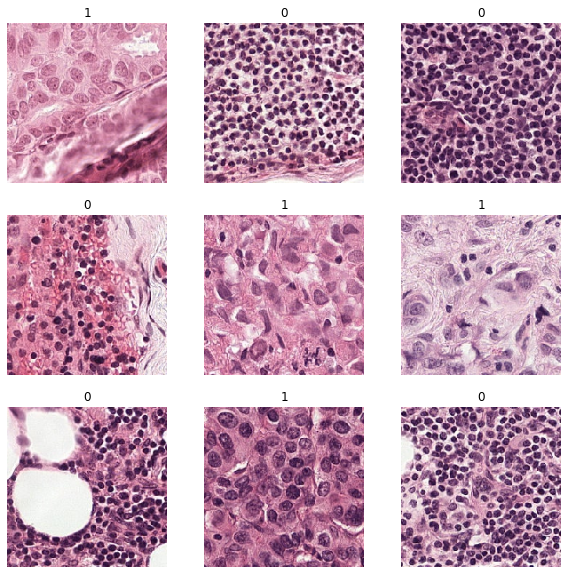

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i,:,:,:].astype("uint8"))
    plt.title(int(y[i]))

    plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


model.fit(X, y, epochs=1
)

2021-11-04 18:23:19.331569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 18:23:21.562245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


1/1 [==============================] - 6s 6s/step - loss: 0.6548 - accuracy: 0.6562


In [ ]:
X.shape

In [20]:
model.predict(X)

array([[0.5021525 ],
       [0.50212926],
       [0.5020143 ],
       [0.5023225 ],
       [0.5021633 ],
       [0.5019631 ],
       [0.50208807],
       [0.502199  ],
       [0.5020308 ],
       [0.5020806 ],
       [0.5022393 ],
       [0.5020517 ],
       [0.5019743 ],
       [0.5020558 ],
       [0.50214815],
       [0.5022097 ],
       [0.50220925],
       [0.50226307],
       [0.5020682 ],
       [0.50197786],
       [0.5022004 ],
       [0.50216204],
       [0.50207895],
       [0.50222784],
       [0.501962  ],
       [0.5019751 ],
       [0.5021523 ],
       [0.50207525],
       [0.50204223],
       [0.502238  ],
       [0.5022449 ],
       [0.5020369 ]], dtype=float32)

In [26]:
model.save("my_model2",save_format="h5")

In [24]:
model.load("my_model.h5")

AttributeError: 'Functional' object has no attribute 'load'

In [28]:
7*10*32

2240